<a href="https://colab.research.google.com/github/rawanmahdi/retinopathy-explained/blob/main/GradCAM_retinopathy.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import tensorflow as tf
import numpy as np
import random
import matplotlib.pyplot as plt
from google.colab import drive
import pandas as pd
import cv2
import random
from tqdm import tqdm
import os
from skimage import io
from imblearn.over_sampling import ADASYN
import keras.backend as K
from IPython.display import Image, display
import matplotlib.cm as cm

In [2]:
drive.mount('/content/gdrive')
model = tf.keras.models.load_model("/content/gdrive/My Drive/retinopathy-explained/accuracy_93")
model.summary()

Mounted at /content/gdrive
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 112, 112, 64  9472        ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 112, 112, 64  256        ['conv2d[0][0]']                 
 alization)                     )                                  

In [3]:
image_size = 224
sample_size = 1000

def crop_image(image_file):
    #drive.mount('/content/gdrive')
    img = io.imread(image_file)
    #print(img)
    img=cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img_copy=img.copy()
    lower=np.array([10,10,10])
    higher=np.array([250,250,250])
    mask=cv2.inRange(img, lower, higher)
    contours, hierarchy = cv2.findContours(image= mask,
                                           mode=cv2.RETR_EXTERNAL,
                                           method=cv2.CHAIN_APPROX_NONE)
    sorted_contours=sorted(contours, key=cv2.contourArea, reverse= True)

    cont_img=cv2.drawContours(image=img, contours=sorted_contours, contourIdx=0,
                              color=(0,255,0),thickness=3)
    c=sorted_contours[0]
    x,y,w,h = cv2.boundingRect(c)
    cv2.rectangle(img=img, pt1=(x,y), pt2=(x+w,y+h), color=(0,255,0), thickness=3)
    cropped_image=img_copy[y:y+h+1, x:x+w+1]
    hsv_img = cv2.cvtColor(cropped_image, cv2.COLOR_BGR2HSV)
    h,s,v = hsv_img[:,:,0], hsv_img[:,:,1], hsv_img[:,:,2]
    clahe = cv2.createCLAHE(clipLimit= 2, tileGridSize=(10,10))
    v = clahe.apply(v)
    hsv_img = np.dstack((h,s,v))
    image = cv2.cvtColor(hsv_img, cv2.COLOR_HSV2RGB)
    #image = cv2.fastNlMeansDenoising(image, None, h=10, templateWindowSize=7, searchWindowSize=21)
    image = cv2.normalize(image, None, alpha=0, beta=1, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_32F)
    image = cv2.resize(image,(image_size,image_size))
    return image

In [4]:
import os

cataract_images = []
glaucoma_images = []
normal_images = []
retinopathy_images = []


for filename in os.listdir('/content/gdrive/My Drive/retinopathy-explained/dataset/normal'):
  normal_images.append('/content/gdrive/My Drive/retinopathy-explained/dataset/normal/'+ filename)

for filename in os.listdir('/content/gdrive/My Drive/retinopathy-explained/dataset/cataract'):
  cataract_images.append('/content/gdrive/My Drive/retinopathy-explained/dataset/cataract/'+ filename)

for filename in os.listdir('/content/gdrive/My Drive/retinopathy-explained/dataset/glaucoma'):
  glaucoma_images.append('/content/gdrive/My Drive/retinopathy-explained/dataset/glaucoma/'+ filename)

for filename in os.listdir('/content/gdrive/My Drive/retinopathy-explained/dataset/diabetic_retinopathy'):
  retinopathy_images.append('/content/gdrive/My Drive/retinopathy-explained/dataset/diabetic_retinopathy/'+ filename)
print(len(normal_images))
print(len(retinopathy_images))

1074
1098


In [5]:
# CREATE SUBDATASET - contains only a single type of disease, this is used for generating samples for the explanations
subsample_size = 10
# shuffle so we get different images every time
random.shuffle(cataract_images)
random.shuffle(normal_images)
random.shuffle(glaucoma_images)
random.shuffle(retinopathy_images)

def create_subdataset(image_category):
  images = []
  for img in tqdm(image_category[:subsample_size]):
    image_path = img
    try:
      image = crop_image(image_path)
    except:
      print('except')
      continue
    images.append(np.array(image))
  return np.array(images)

cataract_X = create_subdataset(cataract_images)
normal_X = create_subdataset(normal_images)
glaucoma_X = create_subdataset(glaucoma_images)
retinopathy_X = create_subdataset(retinopathy_images)

100%|██████████| 10/10 [00:02<00:00,  3.83it/s]


In [6]:
class GradCAM:
  def __init__(self, model, classIdx, layerName=None):
    self.model = model
    self.classIdx = classIdx
    self.layerName = layerName

    if self.layerName is None:
      for layer in (self.model.layers):
        if len(layer.output_shape) == 4:
          self.layerName = layer.name
        else:
          raise ValueError("Could not find 4D layer, GradCAM cannot be applied")
  def get_gradcam_heatmap(self, img, eps=1e-8):
    # add dim to img
    img = np.expand_dims(img, axis=0)

    # build model that maps input image to activations of last convolutional layer of model
    grad_model = tf.keras.models.Model(
        inputs=self.model.inputs,
        outputs=[self.model.get_layer(self.layerName).output, self.model.output]
    )

    # compute gradient of top predicted class for img with respect to activation of last convolutional layer
    with tf.GradientTape() as tape:
      conv_output, preds = grad_model(img)
      loss = preds[:, self.classIdx]

    # get gradient of output with respact to output of feature map of last convolutional layer
    grads = tape.gradient(loss, conv_output)

    # vector of mean intensity of gradient over specified feature map channel
    pooled_grads = tf.reduce_mean(grads, axis=(0,1,2))

    # get heatmap by summing all the channels after multiplying feature map by feature importance for top predicted class
    conv_output = conv_output[0]
    heatmap = conv_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap).numpy()

    # normalize heatmap
    numer = heatmap - np.min(heatmap)
    denom = (heatmap.max() - heatmap.min()) + eps
    heatmap = numer / denom
    heatmap = (heatmap * 255).astype("uint8")

    return heatmap

BUILDING GRADCAM CLASS

In [7]:
labels = {0:'normal',
          1:'cataract',
          2:'glaucoma',
          3:'retinopathy'}
import imutils

In [8]:
def build_heatmap(model, img, predictedClass, layerName, classIdx=None,
                    activation_of_truth=True):
  # get heatmap
  if activation_of_truth:
    Idx = classIdx
    if Idx == None:
      Idx = predictedClass
  else:
    Idx = predictedClass

  heatmapBuilder = GradCAM(model, Idx, layerName)
  heatmap = heatmapBuilder.get_gradcam_heatmap(img)
  heatmap = cv2.resize(heatmap, (224, 224))
  return heatmap

In [10]:
from mpl_toolkits.axes_grid1 import ImageGrid
# random helper function to extract array names
def namestr(obj, namespace):
    return [name for name in namespace if namespace[name] is obj]

In [12]:
def display_40_grid(model, img_arrays):
  # get maps and predictions for each image
  maps = np.zeros((4,10,224,224))
  all_preds = []

  for i in range(len(img_arrays)):
    imgs = img_arrays[i]
    preds = model.predict(imgs, verbose=0)
    all_preds.append(preds)
    for j in range(len(imgs)):
      pred = np.argmax(preds[j])
      img = imgs[j]
      map = build_heatmap(model, img, pred, layerName='conv2d_14', activation_of_truth=False)
      maps[i][j] = map
      j+=1
    i+=1
  # init plot
  fig = plt.figure(figsize=(24,24), frameon=False)
  grid = ImageGrid(fig, 111,
                  nrows_ncols=(4,10),
                  axes_pad=0.3)

  # helper function to derive index mapping between grid and images
  def get_fig_ids(n):
    if(n<10):
      i = 0
      j = n
    else:
      n = str(n)
      i = int(n[0])
      j = int(n[1])
    return img_arrays[i][j], maps[i][j], all_preds[i][j]

  # enumerate grid with images
  i=0
  extent = 0, 224, 0, 224
  for i in range(len(img_arrays[0])*4):
    img, map, pred = get_fig_ids(i)
    grid[i].imshow(img, extent=extent)
    grid[i].imshow(map, cmap=plt.cm.viridis, alpha=0.65, extent=extent)
    grid[i].set_title(f"Predicted {labels.get(np.argmax(pred))}")

  # add labels to rows
  rows = ['True Normal', 'True Cataract', 'True Glaucoma', 'True Retinopathy']
  axes = [grid[0], grid[10], grid[20],grid[30]]
  for ax, row in zip(axes, rows):
      ax.set_ylabel(row)

  plt.show()

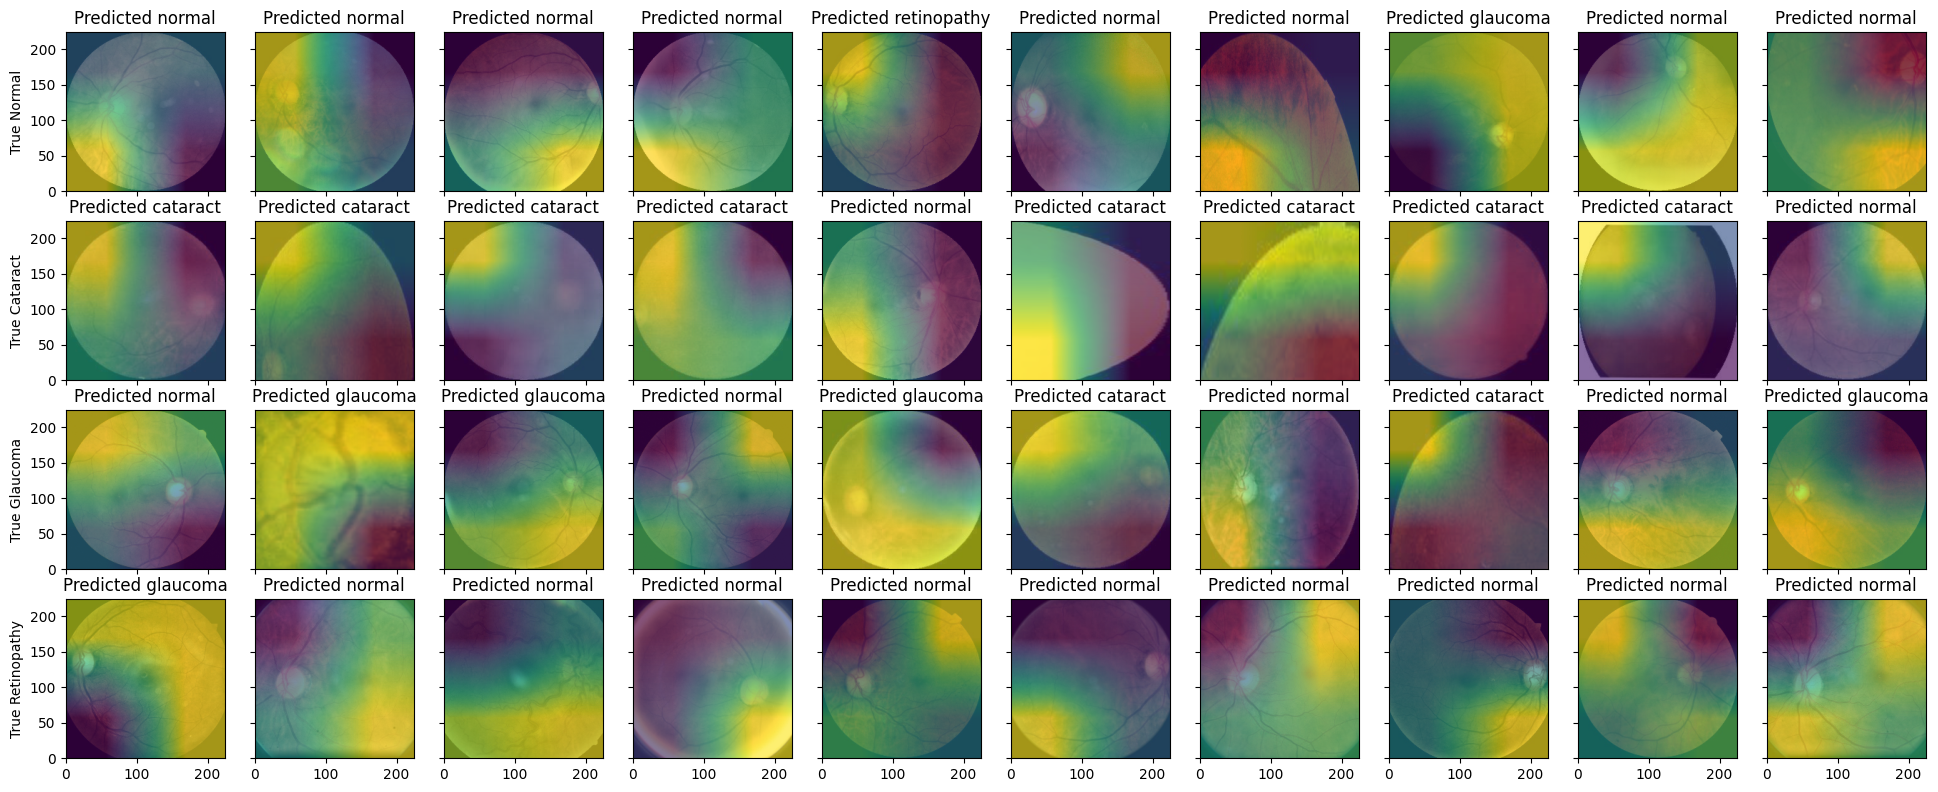

In [13]:
testing_img_arrays =  [normal_X, cataract_X, glaucoma_X, retinopathy_X]
display_40_grid(model ,testing_img_arrays)

TRAINING DATASET

In [15]:
ground_truth_df = pd.read_excel("/content/gdrive/My Drive/retinopathy-explained/Ocular_Disease_Recognition/ODIR-5K/ODIR-5K/data.csv")
ground_truth_df.head(5)

ID  Patient Age Patient Sex Left-Fundus Right-Fundus  \
0   0           69      Female  0_left.jpg  0_right.jpg   
1   1           57        Male  1_left.jpg  1_right.jpg   
2   2           42        Male  2_left.jpg  2_right.jpg   
3   3           66        Male  3_left.jpg  3_right.jpg   
4   4           53        Male  4_left.jpg  4_right.jpg   

                            Left-Diagnostic Keywords  \
0                                           cataract   
1                                      normal fundus   
2  laser spot，moderate non proliferative retinopathy   
3                                      normal fundus   
4                        macular epiretinal membrane   

                Right-Diagnostic Keywords  N  D  G  C  A  H  M  O  
0                           normal fundus  0  0  0  1  0  0  0  0  
1                           normal fundus  1  0  0  0  0  0  0  0  
2  moderate non proliferative retinopathy  0  1  0  0  0  0  0  1  
3         branch retinal artery occlusion  0  0  0  0  0  0  0  1  
4       mild nonproliferative retinopathy  0  1  0  0  0  0  0  1

In [16]:
# accessing all training and testing retinal fundus images
training_filenames = []
testing_filenames = []

for filename in os.listdir('/content/gdrive/My Drive/retinopathy-explained/Ocular_Disease_Recognition/ODIR-5K/ODIR-5K/Testing Images'):
  testing_filenames.append(filename)

for filename in os.listdir('/content/gdrive/My Drive/retinopathy-explained/Ocular_Disease_Recognition/ODIR-5K/ODIR-5K/Training Images'):
  training_filenames.append(filename)

In [17]:
# functions to narrow down dataframe

# diabetic retinopathy
def has_retinopathy(text):
    if "retinopathy" in text:
        return 1
    else:
        return 0

# glaucoma
def has_glaucoma(text):
    if "glaucoma" in text:
        return 1
    else:
        return 0

# normal
def has_normal(text):
    if "normal" in text:
        return 1
    else:
        return 0

# cataract
def has_cataract(text):
    if "cataract" in text:
        return 1
    else:
        return 0



In [18]:
ground_truth_df["left_glaucoma"] = ground_truth_df["Left-Diagnostic Keywords"].apply(lambda x: has_glaucoma(x))
ground_truth_df["right_glaucoma"] = ground_truth_df["Right-Diagnostic Keywords"].apply(lambda x: has_glaucoma(x))
left_glaucoma = ground_truth_df.loc[(ground_truth_df.G ==1) & (ground_truth_df.left_glaucoma == 1)]["Left-Fundus"].values
right_glaucoma = ground_truth_df.loc[(ground_truth_df.G ==1) & (ground_truth_df.right_glaucoma == 1)]["Right-Fundus"].values
glaucoma_images = np.concatenate((left_glaucoma,right_glaucoma),axis=0)


ground_truth_df["left_normal"] = ground_truth_df["Left-Diagnostic Keywords"].apply(lambda x: has_normal(x))
ground_truth_df["right_normal"] = ground_truth_df["Right-Diagnostic Keywords"].apply(lambda x: has_normal(x))
left_normal = ground_truth_df.loc[(ground_truth_df.C ==0) & (ground_truth_df.left_normal == 1)]["Left-Fundus"].values
right_normal = ground_truth_df.loc[(ground_truth_df.C ==0) & (ground_truth_df.right_normal == 1)]["Right-Fundus"].values
normal_images = np.concatenate((left_normal,right_normal),axis=0)


ground_truth_df["left_retinopathy"] = ground_truth_df["Left-Diagnostic Keywords"].apply(lambda x: has_retinopathy(x))
ground_truth_df["right_retinopathy"] = ground_truth_df["Right-Diagnostic Keywords"].apply(lambda x: has_retinopathy(x))
left_retinopathy = ground_truth_df.loc[(ground_truth_df.D ==1) & (ground_truth_df.left_retinopathy == 1)]["Left-Fundus"].values
right_retinopathy = ground_truth_df.loc[(ground_truth_df.D ==1) & (ground_truth_df.right_retinopathy == 1)]["Right-Fundus"].values
retinopathy_images = np.concatenate((left_retinopathy,right_retinopathy),axis=0)


ground_truth_df["left_cataract"] = ground_truth_df["Left-Diagnostic Keywords"].apply(lambda x: has_cataract(x))
ground_truth_df["right_cataract"] = ground_truth_df["Right-Diagnostic Keywords"].apply(lambda x: has_cataract(x))
left_cataract = ground_truth_df.loc[(ground_truth_df.C ==1) & (ground_truth_df.left_cataract == 1)]["Left-Fundus"].values
right_cataract = ground_truth_df.loc[(ground_truth_df.C ==1) & (ground_truth_df.right_cataract == 1)]["Right-Fundus"].values
cataract_images = np.concatenate((left_cataract,right_cataract),axis=0)

# printing lengths of training sets for each class
print( len(normal_images), len(cataract_images), len(retinopathy_images), len(glaucoma_images))

3047 313 1820 326


In [21]:
subsample_size = 100
random.shuffle(cataract_images)
random.shuffle(normal_images)
random.shuffle(glaucoma_images)
random.shuffle(retinopathy_images)

dataset_dir = "/content/gdrive/My Drive/retinopathy-explained/Ocular_Disease_Recognition/preprocessed_images"

def create_subdataset(image_category):
  images = []
  for img in tqdm(image_category[:subsample_size]):
    image_path = dataset_dir + '/' + img
    try:
      image = crop_image(image_path)
    except:
       continue
    images.append(np.array(image))
  return np.array(images)

cataract_X_TRAIN = create_subdataset(cataract_images)
normal_X_TRAIN = create_subdataset(normal_images)
glaucoma_X_TRAIN = create_subdataset(glaucoma_images)
retinopathy_X_TRAIN = create_subdataset(retinopathy_images)

100%|██████████| 100/100 [00:10<00:00,  9.47it/s]


In [22]:
print(cataract_X_TRAIN.shape)
print(normal_X_TRAIN.shape)
print(glaucoma_X_TRAIN.shape)
print(retinopathy_X_TRAIN.shape)


(82, 224, 224, 3)
(56, 224, 224, 3)
(94, 224, 224, 3)
(20, 224, 224, 3)


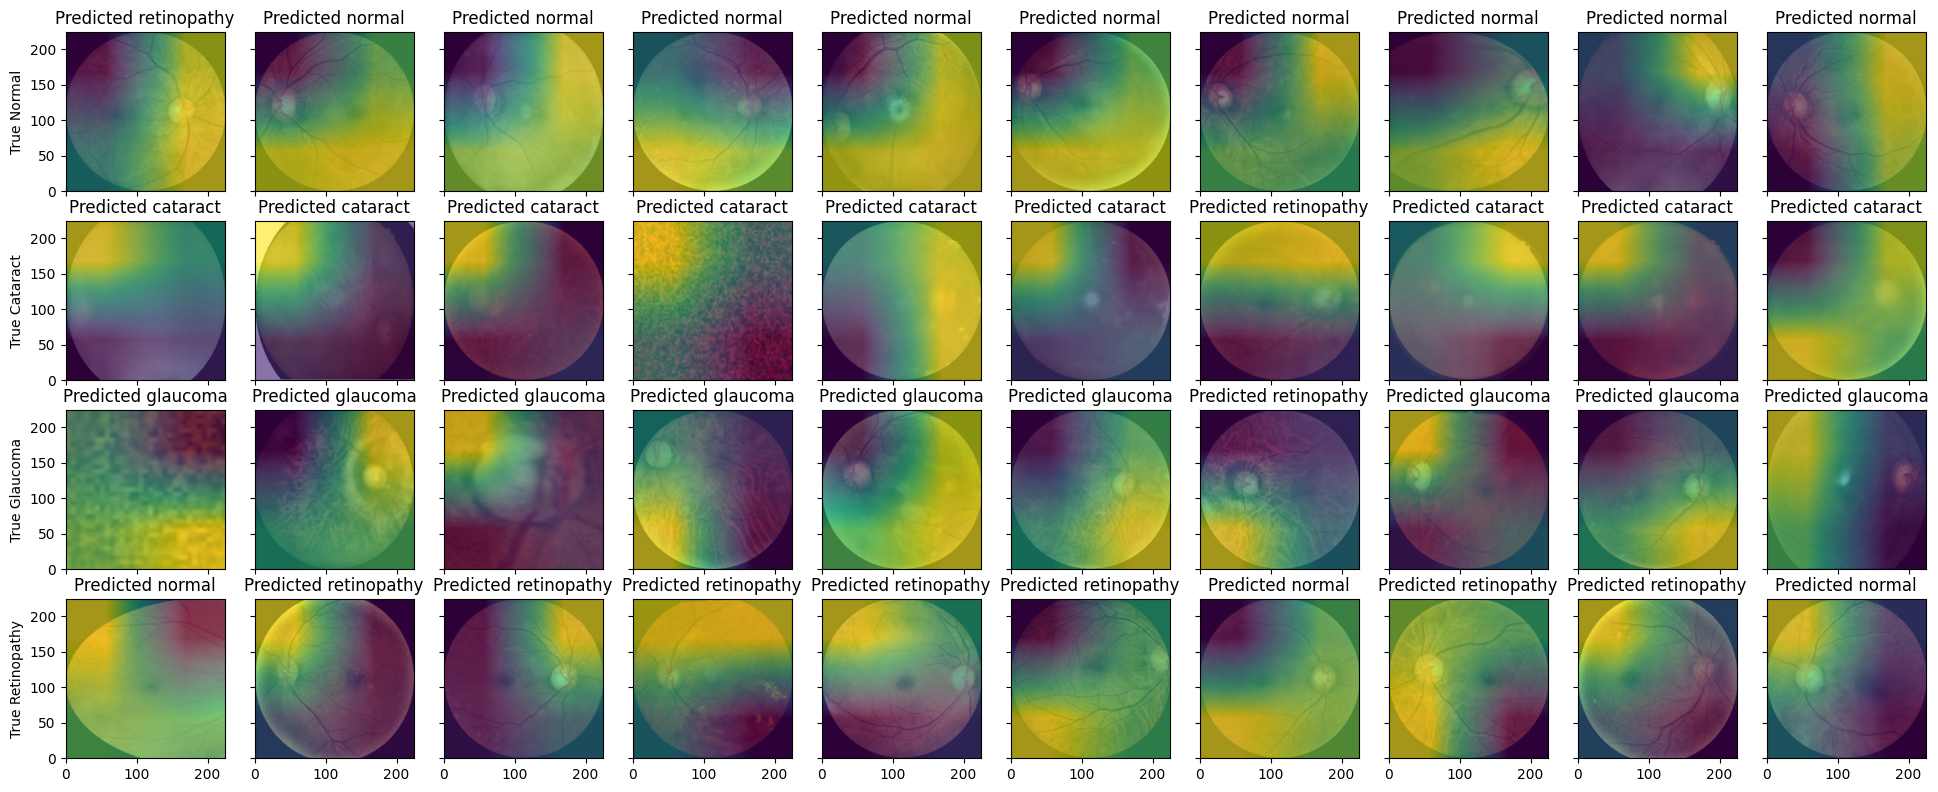

In [23]:
training_img_arrays = [normal_X_TRAIN[:10], cataract_X_TRAIN[:10], glaucoma_X_TRAIN[:10], retinopathy_X_TRAIN[:10]]
display_40_grid(model, training_img_arrays)

TEST ON VGG16

In [ ]:
from keras.applications.vgg16 import VGG16
model = VGG16(weights='imagenet')

In [ ]:
img_path =  "/content/gdrive/My Drive/retinopathy-explained/VGG16_images/meso-grass.jpg"
img = tf.keras.preprocessing.image.load_img(img_path, target_size=(224, 224))
img = tf.keras.preprocessing.image.img_to_array(img)
pred_img = np.expand_dims(img, axis=0)

np.argmax(model.predict(pred_img))

1/1 [==============================] - 1s 1s/step


283

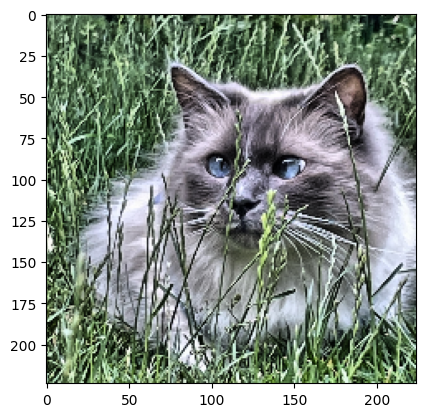

In [ ]:
img = crop_image(img_path)
plt.imshow(img)

In [ ]:
model.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

BLOCK 5 CONV2 LAYER


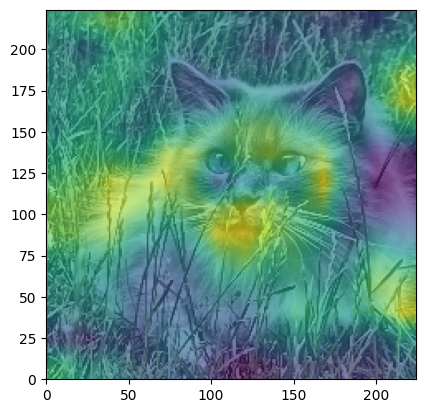

In [ ]:
print("BLOCK 5 CONV2 LAYER")
display_heatmap(model, img, 283, layerName='block5_conv2', activation_of_truth=False)

BLOCK 5 CONV3 LAYER


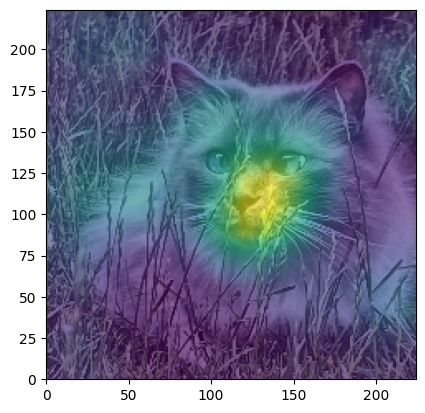

In [ ]:
print("BLOCK 5 CONV3 LAYER")
display_heatmap(model, img, 283, layerName='block5_conv3', activation_of_truth=False)

BLOCK 5 POOLING LAYER


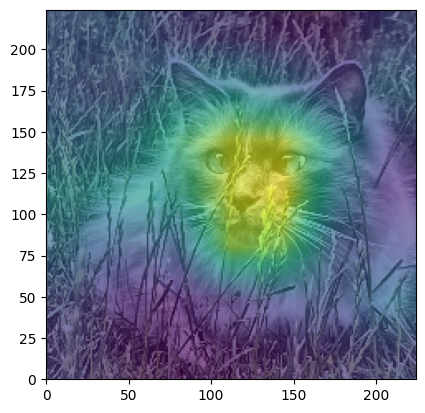

In [ ]:
print("BLOCK 5 POOLING LAYER")
display_heatmap(model, img, 283, layerName='block5_pool', activation_of_truth=False)